# Basic Normalizing Flow Training and Sampling

This notebook is the first in a series of [InvertibleNetworks.jl](https://github.com/slimgroup/InvertibleNetworks.jl). In this tutorial, we will layout the basic theory behind [Normalizing Flows (NFs)](https://arxiv.org/abs/1505.05770) and how to use the implementations in InvertibleNetworks.jl to train and sample from a basic NF. [The following notebook](https://github.com/slimgroup/SLIMTutorials/blob/main/08_conditional_normalizing_flow.ipynb) in the series demonstrates how to train a conditional normalizing flow. You can also learn the concept and ideology of [InvertibleNetworks.jl](https://github.com/slimgroup/InvertibleNetworks.jl) package in the [JuliaCon 2021](https://juliacon.org/2021/) presentation with the youtube video [here](https://www.youtube.com/watch?v=9M-zEGHY4i4).

In this tutorial, we train an NF using the [GLOW](https://proceedings.neurips.cc/paper/2018/file/d139db6a236200b21cc7f752979132d0-Paper.pdf) architecture, which implements:
* Affine couplying layer from [Real-NVP](https://arxiv.org/abs/1605.08803)
* Ability to activate multiscale for efficient training and compressive behavior in latent $z$ 
* ActNorms for stable training   
* 1x1 Convolutions for channel mixing between affine couplying layers  

In [1]:
using InvertibleNetworks
using LinearAlgebra
using PyPlot
using Flux
using Random
using SpecialFunctions
using Distributions

import Flux.Optimise: ADAM, update!
Random.seed!(1234)

PyPlot.rc("font", family="serif"); 

## What is normalizing flow

Normalizing flow (NF) is a type of invertible neural network (INN) containing a series of invertible layers, which aims to learn a probability distribution (e.g. cat images). After training, NF can output a white noise image given an input as a cat image in the distribution. Thanks to its invertibility, we can easily draw sample images from the "cat" distribution by drawing random white noise and apply the inverse of the NF.

## Target distribution

For this example, we will learn to sample from the [2-D Rosenbrock distribution](https://en.wikipedia.org/wiki/Rosenbrock_function). Accessible in InvertibleNetworks.jl
using its colloquial name: the "banana" distribution. The idea of invertible networks is that we want to learn an invertible nonlinear mapping $G$ such that

$$G_{\theta}(x) = z,$$

where $\theta$ is the network parameter, $x$ samples from the target distribution, $z$ samples from Gaussian distribution (white noise). After training, NF can sample from the target distribution via evaluating the inverse of NF on white noise, i.e., $G^{-1}_{\theta}(z)$. Let's first generate a training set and plot the target banana distribution.

In [2]:
n_train = 60000;
X_train = 0.01*sample_banana(n_train);

# X1 = rand(Uniform(-5, 5), n_train)
# X2 = sin.(X1)   # sinusoidal data
# # X2 = 50 .* X1 .^ 2   # parabolic data
# X_train = zeros(1, 1, 2, n_train)
# X_train[1, 1, 1, :] = X1
# X_train[1, 1, 2, :] = X2

size(X_train) #(nx, ny, n_channels, n_samples) Note: we put 2 dimensions as channels

(1, 1, 2, 60000)

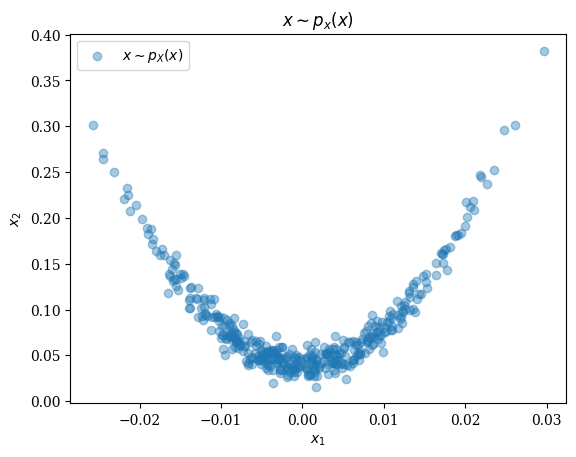

In [3]:
fig = figure(); title(L"x \sim p_x(x)")
scatter(X_train[1,1,1,1:400], X_train[1,1,2,1:400]; alpha=0.4, label = L"x \sim p_{X}(x)");
xlabel(L"x_1"); ylabel(L"x_2");
# xlim(-4,4); ylim(0,30);
legend();

## Change of variables formula

$$p_x(x) = p_z(f(x)) \, |\det \frac{\partial f}{\partial x}|$$

This formula allows us to evaluate the density of a sample under a monotone function $f : \mathbf{X} \rightarrow
 \mathbf{Z}$. 
 
 This density estimation is what gives us a maximum likelihood framework for training our parameterized Normalizing Flow $G_{\theta}$. 

## Training a normalizing flow 

NF training is based on likelihood maximization of the parameterized model $f_{\theta}$ under the log likelihood of samples from the data distribution X: 

$$\underset{\mathbf{\theta}}{\operatorname{argmax}} \mathbb E_{{x} \sim p(x)} [\log p(x)]. $$

We approximate the expectation with Monte Carlo samples from the training dataset:

$$\underset{\mathbf{\theta}}{\operatorname{max}}   \frac{1}{N} \sum_{x \in X_{train}} \log p(x). $$

We make this a minimization problem by looking at the negative loglikelihood and then the change of variabes formula makes this:

$$\underset{\mathbf{\theta}}{\operatorname{min}}   \frac{1}{N} \sum_{x \in X_{train}} -\log p(x) =  \frac{1}{N} \sum_{x \in X_{train}}  [\frac{1}{2}\|G_\theta({x})\|_2^2 - \log | \det \nabla_{x} G_\theta(x) | ]  $$

This means that you apply your network to your data $\hat z = G_\theta(x)$ and want $\hat z$ to look like Normal noise. The log det of the jacobian term is making sure that we learn a distribution. 

Calling ``G.backward`` will set all the gradients of the trainable parameters in `G`. We can access these parameters and their gradients with ``get_params`` and update them with the optimizer of our choice.

Note: since the network is invertible, we do not need to save intermediate states to calculate the gradient. Instead, we only provide the ``G.backward`` function with the final output `Z` and it will recalculate the intermediate states to calculate the gradients at each layer while backpropagating the residual `dZ`. 

In [4]:
# function loss(G, X)
#     batch_size = size(X)[end] 
    
#     Z, lgdet = G.forward(X)
    
#     l2_loss = 0.5*norm(Z)^2 / batch_size  #likelihood under Normal Gaussian training 
#     dZ = Z / batch_size                   #gradient under Normal Gaussian training
    
#     G.backward(dZ, Z)  #sets gradients of G wrt output and also logdet terms
    
#     return (l2_loss, lgdet)
# end

function log_prob(Z)
    # likelihood = -0.5*norm(Z)^2   # for sanity check. Recover normalizing flow result.
    
    cons = loggamma(0.5*(ν+d)) - loggamma(0.5*ν) - 0.5*d*log(pi*ν)
    # input_norms = utils.sum_except_batch(((Z)^2), num_batch_dims=1)
    likelihood = cons - 0.5*(ν + d) * log(1 + (1/ν) * norm(Z)^2)
    
    return -likelihood
end

function loss(G, X)
    batch_size = size(X)[end]
    
    Z, lgdet = G.forward(X)
    
    function l2_loss(Z)
        return log_prob(Z) / batch_size
    end
    
    # use AD
    θ = Flux.params([Z])
    back = Flux.Zygote.pullback(() -> l2_loss(Z), θ)[2]
    grad = back(1f0)
    logprob_grad = grad[θ[1]]
    
    G.backward(logprob_grad, Z)  # sets gradients of G wrt output and also logdet terms
    
    return (l2_loss(Z), lgdet, logprob_grad, Z)
end

loss (generic function with 1 method)

In [5]:
nx          = 1
ny          = 1

#network architecture
n_in        = 2 #put 2d variables into 2 channels
n_hidden    = 16
levels_L    = 1
flowsteps_K = 10
eps = 1

G = NetworkGlow(n_in, n_hidden, levels_L, flowsteps_K;)
#G = G |> gpu 

#training parameters
batch_size = 50
maxiter    = cld(n_train, batch_size)

lr = 9f-4
opt = ADAM(lr)

ν = 100
d = 2   # 2-d data throughout this notebook

loss_l2_list    = zeros(maxiter)
loss_lgdet_list = zeros(maxiter)

for ep in 1:eps
    for j = 1:maxiter
        Base.flush(Base.stdout)
        # idx = ((j-1)*batch_size+1):(j*batch_size)
        idx = rand(1:n_train, batch_size)

        X = X_train[:,:,:,idx]
        #x = x |> gpu

        losses = loss(G, X) #sets gradients of G

        loss_l2_list[j]    = losses[1]
        loss_lgdet_list[j] = losses[2]

        (j%50==0) && println("Iteration=", j, "/", maxiter,
                "; f l2 = ",   loss_l2_list[j], 
                "; f lgdet = ",loss_lgdet_list[j], 
                "; f nll objective = ",loss_l2_list[j] - loss_lgdet_list[j])

        for p in get_params(G) 
            update!(opt,p.data,p.grad)
        end
    end
end

Iteration=50/1200; f l2 = 1.0435802564301908; f lgdet = 7.922629859838562; f nll objective = -6.879049603408371
Iteration=100/1200; f l2 = 1.503275455987863; f lgdet = 9.145692338684333; f nll objective = -7.64241688269647
Iteration=150/1200; f l2 = 2.1552795913582266; f lgdet = 9.522863637764472; f nll objective = -7.367584046406245
Iteration=200/1200; f l2 = 2.90173580740139; f lgdet = 10.51776596503018; f nll objective = -7.6160301576287885
Iteration=250/1200; f l2 = 2.460913779738978; f lgdet = 10.419738948381328; f nll objective = -7.95882516864235
Iteration=300/1200; f l2 = 2.923664665959627; f lgdet = 10.587582709790981; f nll objective = -7.663918043831353
Iteration=350/1200; f l2 = 2.779216683837437; f lgdet = 10.835001518466857; f nll objective = -8.05578483462942
Iteration=400/1200; f l2 = 4.008955593225808; f lgdet = 11.427766397994436; f nll objective = -7.418810804768627
Iteration=450/1200; f l2 = 2.901943775674016; f lgdet = 11.493135807230743; f nll objective = -8.59119

## Check training objective log 
There are various ways to train a NF:
- train your network to convergence of objective
- use earlystopping to prevent overfitting 
- check normality of $\hat z = G_{\theta}(x)$ with [qq plots](https://en.wikipedia.org/wiki/Q%E2%80%93Q_plot) 
- as a heuristic simply observe $\hat z = G_{\theta}(x)$ until it looks normal under the eyeball norm. 

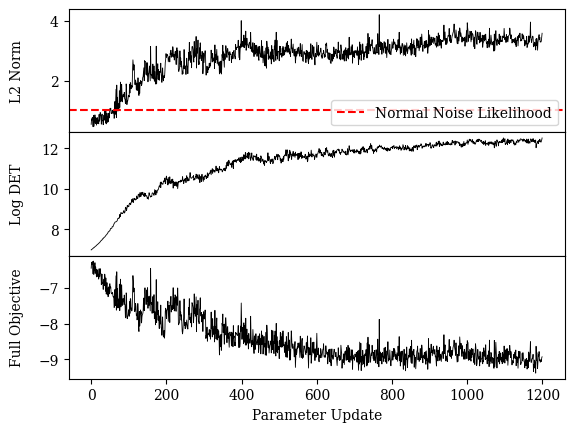

PyObject Text(0.5, 24.0, 'Parameter Update')

In [6]:
gt_l2 = 0.5*nx*ny*n_in #likelihood of gaussian noise

fig, axs = subplots(3, 1, sharex=true)
fig.subplots_adjust(hspace=0)

axs[1].plot(loss_l2_list, color="black", linewidth=0.6); 
axs[1].axhline(y=gt_l2,color="red",linestyle="--",label="Normal Noise Likelihood")
axs[1].set_ylabel("L2 Norm")
axs[1].yaxis.set_label_coords(-0.09, 0.5)
axs[1].legend()

axs[2].plot(loss_lgdet_list, color="black", linewidth=0.6); 
axs[2].set_ylabel("Log DET") 
axs[2].yaxis.set_label_coords(-0.09, 0.5) 

axs[3].plot(loss_l2_list - loss_lgdet_list, color="black", linewidth=0.6); 
axs[3].set_ylabel("Full Objective") 
axs[3].yaxis.set_label_coords(-0.09, 0.5)
axs[3].set_xlabel("Parameter Update") 

## Testing a Normalizing Flow 
Since we have access to $p_x(x)$ in the simple 2D Rosenbrock distribution, we can verify that generative samples from our trained network  $\hat x = G^{-1}_\theta(z)$  look like they come from $p_x(x)$.

We can verify this visually (easy since this is a 2D dataset) and under the ground truth density of $p_x(x)$.

Let's start by taking samples from $z \sim N(0,I) $

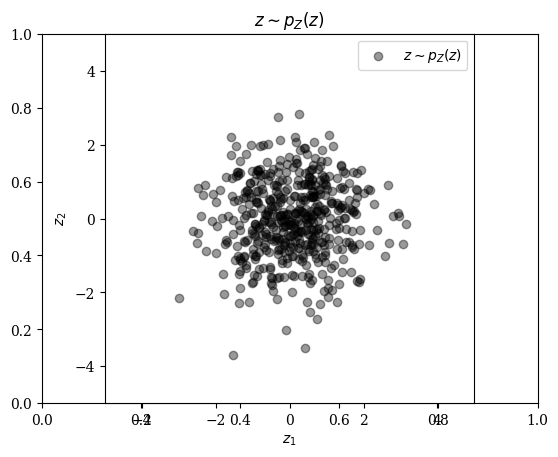

In [7]:
num_test_samples = 500;
# Z_test = randn(Float32,nx,ny,n_in, num_test_samples);
t_dist = TDist(ν)
Z_test = rand(t_dist, nx, ny, n_in, num_test_samples)

fig = figure(); title(L"z \sim p_{Z}(z)")
ax = fig.add_subplot(111);
scatter(Z_test[1,1,1,:], Z_test[1,1,2,:]; alpha=0.4, color="black", label = L"z \sim p_{Z}(z)");
xlabel(L"z_1"); ylabel(L"z_2");
xlim(-5,5); ylim(-5,5);
legend(); 
ax.set_aspect(1);

Pass Normal samples $z \sim N(0,I)$ through the inverse network $\hat x = G^{-1}_\theta(z)$ 

In [8]:
X_test = G.inverse(Z_test);

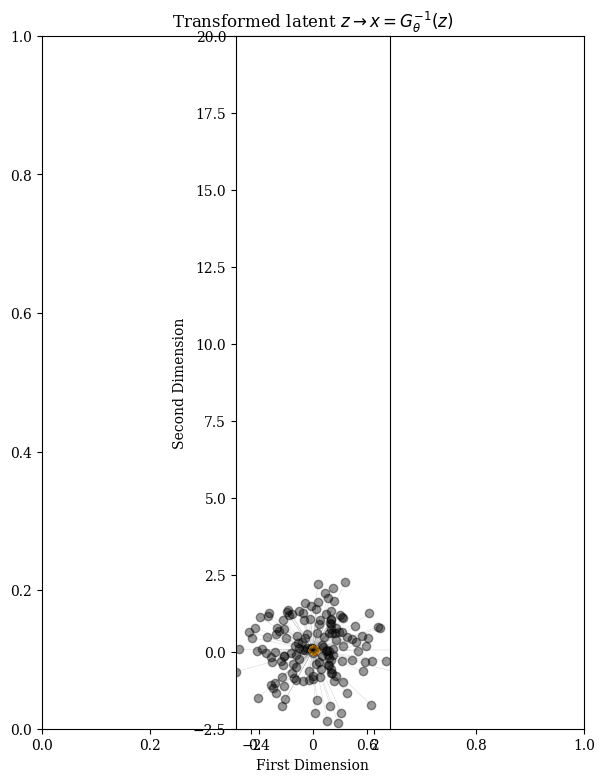

In [9]:
trans_num = 150
start_points = [(Z_test[1,1,1,i], Z_test[1,1,2,i]) for i in 1:trans_num]
end_points = [(X_test[1,1,1,i], X_test[1,1,2,i]) for i in 1:trans_num]

fig = figure(figsize=(7,9)); title(L"Transformed latent $z \rightarrow x=G^{-1}_\theta(z)$");
ax = fig.add_subplot(111)

for line in zip(start_points, end_points)
    plot([line[1][1],line[2][1]], [line[1][2] ,line[2][2]], alpha=0.2, linewidth=0.3, color="black")
    scatter(line[1][1], line[1][2], marker="o",alpha=0.4, color="black")
    scatter(line[2][1], line[2][2], marker="o",alpha=0.4, color="orange")
end
xlabel("First Dimension"); ylabel("Second Dimension");
ylim(-2.5,20); xlim(-2.5,2.5); ax.set_aspect(1)

Visually compare generative samples with samples from the ground truth density $x \sim p_x(x) $

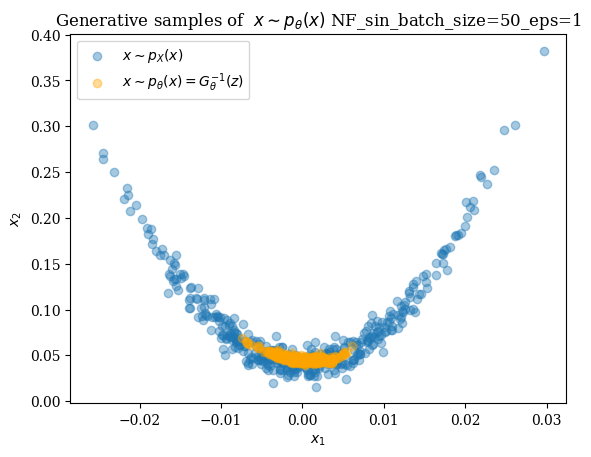

In [10]:
# imgname = "tF_ν=$ν" * "_sin_batch_size=$batch_size" * "_eps=$eps"
imgname = "NF_sin_batch_size=$batch_size" * "_eps=$eps"

fig = figure(); title(L"Generative samples of  $x \sim p_{\theta}(x)$ " * imgname)
scatter(X_train[1,1,1,1:400], X_train[1,1,2,1:400]; alpha=0.4, label = L"x \sim p_{X}(x)");
scatter(X_test[1,1,1,1:400], X_test[1,1,2,1:400]; alpha=0.4, color="orange", label = L"x \sim p_{\theta}(x) = G_\theta^{-1}(z)");
xlabel(L"x_1"); ylabel(L"x_2");
# xlim(-4,4); ylim(0,30);
legend();

imgname = imgname * ".png"
savefig("07_plots/$imgname")

Below are a list of publications in SLIM group that use [InvertibleNetworks.jl](https://github.com/slimgroup/InvertibleNetworks.jl) for seismic/medical imaging, and in general, inverse problems:

[Rafael Orozco, Mathias Louboutin, Felix J. Herrmann. Memory Efficient Invertible Neural Networks for 3D Photoacoustic Imaging. 2022.](https://slim.gatech.edu/Publications/Public/Submitted/2022/orozco2022MIDLmei/midl_2022.html)

[Siahkoohi, Ali, et al. "Wave-equation-based inversion with amortized variational Bayesian inference." arXiv preprint arXiv:2203.15881 (2022).](https://arxiv.org/abs/2203.15881)

[Orozco, Rafael, et al. "Photoacoustic imaging with conditional priors from normalizing flows." NeurIPS 2021 Workshop on Deep Learning and Inverse Problems. 2021.](https://openreview.net/pdf?id=woi1OTvROO1)

[Kumar, Rajiv, et al. "Enabling uncertainty quantification for seismic data preprocessing using normalizing flows (NF)—An interpolation example." First International Meeting for Applied Geoscience & Energy. Society of Exploration Geophysicists, 2021.](https://library.seg.org/doi/abs/10.1190/segam2021-3583705.1)

[Siahkoohi, Ali, and Felix J. Herrmann. "Learning by example: fast reliability-aware seismic imaging with normalizing flows." First International Meeting for Applied Geoscience & Energy. Society of Exploration Geophysicists, 2021.](https://library.seg.org/doi/abs/10.1190/segam2021-3581836.1)